# Recap


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Recap en uitbreiding

Je hebt al gezien hoe je een botsend deeltjesmodel maakt. Je startte toen met 1 of 2 deeltjes en hebt dit uitgebreid naar ~100 deeltjes. Daarbij was het logisch om gebruik te maken van classes.

Voor het maken van een simulatie van gasmoleculen in een gesloten volume zal je logischerwijs de volgende stappen doorlopen:
1. bepalen van initiële condities
2. definiëren van de deeltjes
3. definiëren van volume met randvoorwaarden
4. simulaties bestaande uit:
    - bepaling van positie van deeltjes
    - controleren op onderlinge botsingen 
    - controleren op botsingen met wanden
    - aanpassen van eigenschappen zoals totaal volume of temperatuur
    - opslaan van gegevens
    
```{note}
Alhoewel het interessant is om steeds een animatie te maken van de beweging van de deeltjes, vraagt dit veel rekentijd. Je kan ook regelmatig een plot maken om te controleren of het programma werkt zoals je verwacht.
```

### De initiële condities

In onze simulatie gaan we uit van een aantal aannames. Bij deze aannames wil je dat de simulatie een voorspellende waarde heeft voor een reëel systeem, maar ook dat de benodigde rekenkracht voor het uitvoeren van de simulatie op te brengen is. We kiezen daarom voor de volgende condities:

- Ons model heeft een beperkt en constant aantal deeltjes.
- We maken gebruik van een 2D simulatie.
- De deeltjes voelen geen onderlinge kracht en ondergaan alleen elastische botsingen.
- (tijdens simuleren) De tijdstap is voldoende klein. (d.w.z. de afgelegde weg $v_0*dt$ is klein in vergelijking met de diameter van de deeltjes, zodat we geen botsingen missen)

Hieronder geven we een aantal constanten voor onze code. Om de simulatie straks te kunnen interpreteren, vergelijken we deze eerst met een realistische situatie:

```{exercise} Lucht in een fietsband
:label: ex-recap-1

Als model gaan we uit van een deel van het volume van een fietsband die onder een druk van 10 bar staat. Schat hiervoor het gemiddelde volume $V_{molecuul}$. Het antwoord gebruik je zo direct in de code hieronder. 
```

```{solution} ex-recap-1
1e-3 
```

De simulatie die we gaan maken bevat maar twee dimensies. We kunnen het oppervlak per deeltje in deze simulatie daarom kiezen als het zojuist berekende $V_{molecuul}^{2/3}$.

Voor de gemiddelde snelheid, $v$, van een molecuul geldt dat

$$
    \frac{1}{2}m\left< v^2\right> = \frac{f}{2} k_B T.
$$

Hierbij is $m$ de massa van het deeltje, $f$ het aantal dimensies, $k_B$ de constante van Boltzmann en $T$ de temperatuur.

```{exercise} Snelheid van een gasmolecuul
:label: ex-recap-2
Schat de snelheid van een gasmolecuul bij kamertemperatuur in twee dimensies. Ook deze heb je hierna nodig.
```

```{solution} ex-recap-2
500 /frac{m}{s}
```

```{exercise} Radius
:label: ex-recap-3
Kies de eenheden waarin je de simulatie wilt gaan uitwerken. Dit kan in $\mathrm{m}$ maar ook in $\mathrm{mm}$ of iets anders. Pas de waardes voor de constanten `BOX_SIZE_0` en `V_0` in de hieronder gegeven code aan, zodat de simulatie een redelijk tweedimensionaal model is voor de fietsband. Hou hierbij het aantal deeltjes $N=40$ om de rekentijd van het model te beperken. Kies `RADIUS` gelijk aan 0.3 nm gebruik makend van jouw eenhedenstelsel.
```

```{solution} ex-recap-3
Jouw antwoord
```

```{exercise} DT
:label: ex-recap-4
Pas waarde van `DT` aan zodat de verplaatsing van een deeltje in een tijdstap klein genoeg is om te detecteren of deze met een ander deeltje botst. Zet in het groene commentaar bij elke constante in welk eenheid deze wordt weergegeven.
```

Onze simulatie modelleert dus een klein systeem zonder rekening te houden met de kracht tussen de luchtmoleculen. Je zult zien dat we toch al behoorlijk wat van de processor vragen om deze berekeningen te doen. Om een meer realistische modelsimulatie te maken is daarom een serieuze uitdaging, die veel wiskunde en programmeerervaring vraagt. Op dit ogenblik wordt dit bijvoorbeeld gevraagd bij een van de eerste opdrachten van het vak 'Computational Physics' van de master Applied Physics. 

In [3]:
# Ruimte voor uitwerking
BOX_SIZE_0 = 15e-9               # Hoogte en breedte startvolume (in vul je gekozen eenheid in)
N = 40                          # Aantal deeltjes 
V_0 = 4.1e-2                       # Startsnelheid van deeltjes (vul je gekozen eenheid in)
RADIUS = 0.3e-9                      # Straal van moleculen (vul je gekozen eenheid in)
DT = 5e-9                        # Tijdstap om geen botsing te missen (vul je gekozen eenheid in)

In [4]:
#your code/answer


### Particle class
Onze `ParticleClass` definieert van een deeltje de massa $m$, snelheid $v$, positie $r$, en straal $R$. De positie moet per tijdstap bepaald worden. 

Nieuw aan `ParticleClass` zijn twee properties, nl. `momentum` en `energy`. Een property is eigenlijk een variabele die samenhangt met de waarde van andere variabelen binnen de klasse. Om de interne consistentie te bewaren moet je de juiste waarde van deze variabele dus telkens afleiden en dat doe je met een functie. Zo geeft `kin_energy` de kinetische energie terug van het deeltje door die af te leiden van de variabelen `m` en `v`.

Buiten `ParticleClass` voegen we twee functies toe, die je ook al hebt gezien. De eerste heet `collide_detection` en detecteert of twee deeltjes onderling overlappen en dus botsen. De tweede heet `particle_collision` en berekent de nieuwe snelheden van de twee deeltjes ten gevolge van hun botsing.

In [5]:
# Maken van de class
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    """ Geeft TRUE als de deeltjes overlappen """
    dx = p1.r[0]-p2.r[0]
    dy = p1.r[1]-p2.r[1]
    rr = p1.R + p2.R
    return  dx**2+dy**2 < rr**2 
    #Note: np.linalg.norm(p1.r - p2.r) < (p1.R + p2.R) had ook gekund, maar is veel langzamer. Controleer zelf!

def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
        
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

### Volume en randvoorwaarden

Voor het volume maken we gebruik van het oppervlak van een `pyplot`, net zoals we dat in Q1 gedaan hebben. Daar is op dit ogenblik niets anders voor nodig dan een functie die de deeltjes laat botsen met de wanden.

Je hebt hiervoor al een voorbeeld van gezien, maar hieronder gebruiken we een andere vorm. Als je code ontwikkelt is het zaak om regelmatig en structureel te controleren of je code klopt. Het maakt daarbij niet uit of de code door jezelf is gemaakt, door een ander (zoals de docent) is aangeboden of van een generatieve AI komt. Hoe langer je code toevoegt zonder een controle uit te voeren, hoe groter de kans is dat je fout op fout stapelt en niet meer kan traceren wat er precies mis is. 

We maken gebruik van een truc die in veel simulaties wordt gebruikt: we maken gebruik van periodieke randvoorwaarden. In dit geval wil dit zeggen dat een deeltje dat botst met de wand aan de ene kant van het volume, aan de andere kant verschijnt met exact dezelfde snelheid. Op deze manier verandert de snelheid van een deeltje niet bij het botsen met de wand en blijven alle behoudswetten gelden. Die behoudswetten kunnen we straks goed controleren.

In [6]:
def box_collision(particle: ParticleClass):
    ''' botsing met wanden geeft periodieke randvoorwaarden '''
    for i in range(2):
        if particle.r[i] > BOX_SIZE_0 / 2:
            particle.r[i] -= BOX_SIZE_0 
        elif particle.r[i] < -BOX_SIZE_0 / 2:
            particle.r[i] += BOX_SIZE_0

### Maken van de simulatie

Nu dat we alle benodigde functies hebben, kunnen we ze in de juiste structuur zetten om de simulatie uit te voeren.

#### Bepaling positie deeltjes

Eerst moeten we alle deeltjes aanmaken en de startwaardes van hun variabelen invoeren:


```{exercise}
:label: const_speed
Leg uit dat d.m.v. onderstaande code de deeltjes allemaal dezelfde snelheid hebben en uniform verdeeld zijn over de box.
```

```{solution} const_speed
Jouw antwoord hier...
```

In [7]:
def create_particles(particles):
    ''' Leegmaken en opnieuw aanmaken van deeltjes '''
    particles.clear
    for i in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
        pos = np.random.uniform(-BOX_SIZE_0/2 + RADIUS, BOX_SIZE_0/2 - RADIUS, 2)
        particles.append(ParticleClass(m=1.0, v=[vx, vy], r=pos, R=RADIUS))

#### Controleren op onderlinge botsingen

Om de botsingen van alle deeltjes goed te verwerken moeten we controleren welke paren deeltjes met elkaar moeten botsen en deze botsingen één keer uitvoeren. 

```{exercise}
:label: double_loop
Leg uit hoe er in onderstaande code wordt voorkomen dat de botsing tussen twee deeltjes dubbel wordt uitgevoerd.
```

```{solution} double_loop
door alle particles alleen te vergelijken met particles die hoger in positie particle[] zijn gerangschikt te vergelijken, worden alle combinaties van 2 particles maar 1 keer gedetecteerd```

In [8]:
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

#### Controleren op botsingen met wanden

Voor het bepalen of deeltjes botsen met de wanden maken we gebruik van de functie die we net hebben aangepast.

In [9]:
def handle_walls(particles):
    ''' botsing met wanden controleren voor alle deeltjes in volume '''
    for p in particles:
        box_collision(p)

#### Integreren in tijdstap

Nu moeten we alle functies op de juiste manier combineren om de simulatie een tijdstap te laten maken:

In [10]:
def take_time_step(particles):
    for p in particles:
        p.update_position()
        
    handle_collisions(particles)
    handle_walls(particles)  


### Uitvoeren simulatie en tonen resultaat

Zoals aangegeven, kunnen we een animatie maken van de positie en snelheid als functie van de tijd, maar we kunnen ook het eindresultaat tonen en interpreteren:

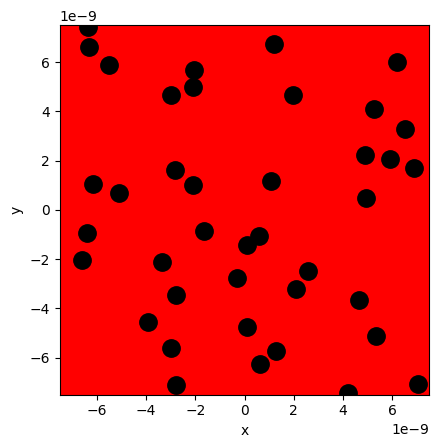

In [11]:
particles = []
create_particles(particles)
for i in range(100):
    take_time_step(particles)

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
plt.ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)

for p in particles:
    plt.plot(p.r[0], p.r[1], 'k.', ms=25)
    plt.arrow(p.r[0], p.r[1], p.v[0], p.v[1], 
              head_width=0.05, head_length=0.1, color='red')
plt.show()

### Toevoegen animatie

Zoals gezegd: het kost veel meer rekenkracht om een animatie te maken over de tijd. Soms kan het wel helpen om te zien of de simulatie aan alle verwachtingen voldoet. 

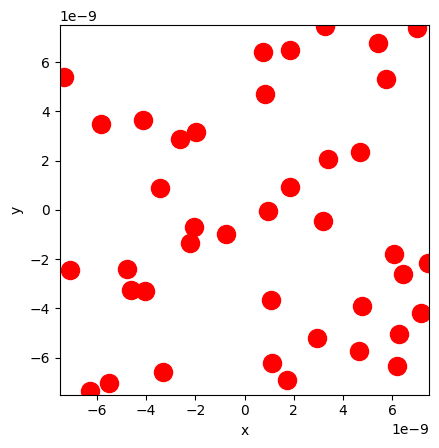

In [12]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

kin_energy_array = []
momentum_array = []

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
ax.set_ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
ax.set_aspect('equal')
dot, = ax.plot([], [], 'ro', ms=13);

def init():
    dot.set_data([], [])
    return dot,

def update(frame):
    take_time_step(particles)
    dot.set_data([p.r[0] for p in particles], [p.r[1] for p in particles])
    kin_energy_dt_array = [p.kin_energy for p in particles]
    kin_energy_dt = np.sum(kin_energy_dt_array)
    kin_energy_array.append(kin_energy_dt) 
    momentum_dt_array = [p.momentum for p in particles]
    momentum_dt = np.sum(momentum_dt_array, axis=0) 
    momentum_array.append(momentum_dt)
    return dot,

ani = FuncAnimation(fig, update, frames=100, init_func=init, blit=True, interval=50)
HTML(ani.to_jshtml())

kin_energy_array = np.array(kin_energy_array)
momentum_array = np.array(momentum_array)

### Controle code

Om te controleren of onze code werkt passen we nu de code aan.

```{exercise}
Voeg aan de simulatie een regel toe die voor elke tijdstap bepaalt wat de totale kinetische energie is voor alle deeltjes en neem deze waarde op in een array die bij elke tijdstap met één element groeit in lengte. Maak een plot van de totale kinetische energie als functie van de tijd gedurende een simulatie van 100 tijdstappen.
```

```{exercise}
:label: ex-recap-6

Maak een plot van de totale kinetische energie als functie van de tijd gedurende een simulatie van 100 tijdstappen.
```

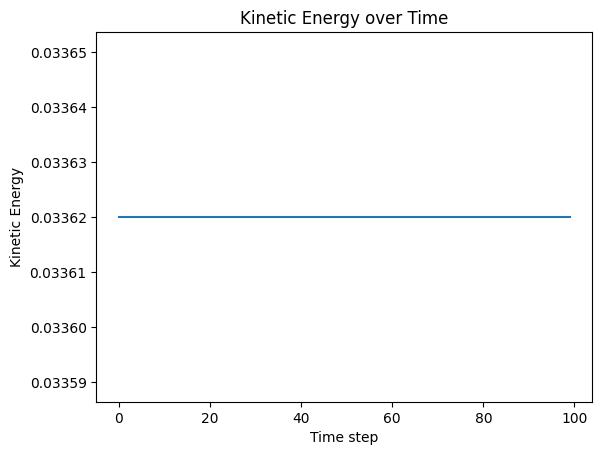

In [13]:
plt.figure()
plt.plot(kin_energy_array)
plt.xlabel('Time step')
plt.ylabel('Kinetic Energy')
plt.ylim(min(kin_energy_array)*0.999, max(kin_energy_array)*1.001)    
plt.title('Kinetic Energy over Time')
plt.show()

In [14]:
#your code/answer


```{exercise} 
:label: error_energy
Als je heel nauwkeurig naar de waarde voor de totale kinetische energie kijkt, dan varieert deze toch. Zoom hiervoor goed in op de as voor de energie. Op welke energieschaal gebeurt dit en is de oorzaak?
```

```{solution} error_energy
Jouw antwoord hier...
```

```{exercise}
:label: more_error
Noem nog een andere grootheid die behouden moet zijn. Geef ook van deze grootheid een plot van de waarde gedurende 100 tijdstappen. Zoom ook hier goed in. Is hier een variatie en zo ja, waardoor?
```



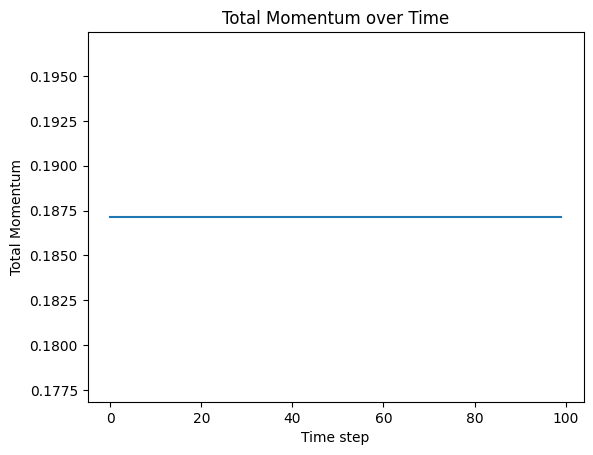

In [15]:
momentum_mag = np.sqrt(np.sum(momentum_array**2, axis=1))

plt.figure()
plt.plot(momentum_mag)
plt.xlabel('Time step')
plt.ylabel('Total Momentum')
plt.title('Total Momentum over Time')
plt.show()



Voor simulaties waarbij de kans op botsingen heel groot is (richting vloeistof), is er een handige methode om de snelheid van je simulatie op te voeren.
In onderstaande code wordt daar een voorbeeld van gegeven.

```{code} python
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])
```

```{exercise} Controleren van beperkingen 🌶 
:label: ex-recap-9

Leg uit wat deze code precies doet. 

Maak een script waarbij twee deeltjes met dezelfde (absolute) snelheid op een derde deeltje afbewegen en tegelijk zouden botsen.
- Laat zien dat 'slechts' twee deeltjes een interactie met elkaar aan gaan.
- Leg uit waarom dat een acceptabele benadering is wanneer je veel deeltjes botsingen per tijdseenheid hebt.
- Voor wie een uitdaging wil: maak een grafiek met het aantal botsingen per tijdseenheid. Dit om bovenstaande benadering verder te verantwoorden.
```

````{tip} Nog sneller
Er is een manier om je script nog sneller te maken. 
Die methode gaat wel voorbij aan wat we verwachten van eerstejaars, maar het idee is de moeite waard om te bekijken.
Bij $N$ deeltjes zou je $\frac{N(N-1)}{2}$ mogelijke botsingen moeten bekijken. 
Door gebruik te maken van een ignore list maak je die mogelijk aantal botsingen al een stuk minder.
Maar je zou ook er van uit kunnen gaan dat botsingen slechts plaats vinden met deeltjes die in de buurt zijn.
Als je een grid maakt en elk deeltje in een grid zet, hoeft elk deeltje slechts in de naastgelegen velden te "kijken" of daar een deeltje aanwezig is waarmee een botsing kan plaats vinden.

In onderstaande figuur is dat weergegeven. 
Het lichtrode deeltje heeft potentieel maar negen mogelijke botsingen. 
Dat script kan verder geoptimaliseerd worden door van links naar rechts per grid te lopen, dan hoeven zelfs niet alle velden bekeken te worden.

```{figure} ../../Figures/grid.png
:width: 50%
```

````

In de volgende notebooks maken we veelal gebruik van numpy functies.
In sommige gevallen is dat sneller, maar lang niet altijd.
Het is good-practice om na te gaan wat sneller is.
Aan de andere kant moet de tekst ook leesbaar blijven...

Als onderdeel om excellent te scoren verwachten we dat je een aantal checks tussendoor doet om code sneller te maken.
In onderstaande testcode, gemaakt door Josh Sleijfer wordt een van die functies getest.
Wat blijkt?
Voor "kleine" vectoren is het sneller om geen gebruik te maken van Numpy maar voor grotere vectoren wel!

```{code} python
import numpy as np
import time

L = 2                # lengte van de vector
repeats = 1_000_000  # aantal herhalingen

rnd_vec1 = np.random.rand(L, repeats)
 
# test numpy dot product
t0 = time.perf_counter()
for vec1 in rnd_vec1.T:
    dot = np.dot(vec1, vec1)
t1 = time.perf_counter()

print(f"Numpy: Time taken for {repeats} dot products of length {L}: {t1 - t0:.4f} seconds")

# test no numpy dot product 
t0 = time.perf_counter()
for vec1 in rnd_vec1.T:
    dot = vec1[0] * vec1[0] + vec1[1] * vec1[1] # + vec1[2] * vec1[2] + vec1[3] * vec1[3] # don't forget to adjust!
t1 = time.perf_counter()

print(f"No Numpy: Time taken for {repeats} dot products of length {L}: {t1 - t0:.4f} seconds")

# test fully vectorized 
t0 = time.perf_counter()
dot = np.sum(rnd_vec1[0] * rnd_vec1[0] + rnd_vec1[1] * rnd_vec1[1])
t1 = time.perf_counter()
print(f"Fully vectorized: Time taken for {repeats} dot products of length {L}: {t1 - t0:.4f} seconds")

```

```{exercise}
Laat je werk aftekenen door een TA
```